In [1]:
%matplotlib inline
import os
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
# from cdo import *
# cdo = Cdo()

from metpy.units import units
from scipy import stats
from scipy.stats import linregress

In [2]:
def flip_lon_tll(da):
    # flip 360 to 180 lon
    # for time-lat-lon xarray dataarray

    # get coords
    lat_da = da.coords["lat"]
    lon_da = da.coords["lon"]
    time_da = da.coords["time"]

    # flip lon
    lon_180 = (lon_da.values + 180) % 360 - 180

    # new data array
    da_180 = xr.DataArray(da.values,
                          coords=[time_da,lat_da.values,lon_180],
                          dims=["time","lat","lon"])

    # flip dataarray so it goes from -180 to 180
    # (instead of 0-180, -180-0)
    lon_min_neg = np.amin(lon_180[lon_180<0])
    lon_max_neg = np.amax(lon_180[lon_180<0])
    lon_min_pos = np.amin(lon_180[lon_180>=0])
    lon_max_pos = np.amax(lon_180[lon_180>=0])
    da_180_flip = xr.concat([da_180.loc[:,:,lon_min_neg:lon_max_neg],
                             da_180.loc[:,:,lon_min_pos:lon_max_pos]],
                            dim="lon")
    return(da_180_flip)

In [3]:
ds = xr.open_mfdataset('/work/mh0033/m301036/LSAT/Merged-CMIP6/tas_hist_MPI*.nc', combine = 'nested', concat_dim = 'run')
ds

<xarray.Dataset>
Dimensions:    (time: 1980, run: 30, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
  * run        (run) int64 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (run, time, bnds) datetime64[ns] dask.array<chunksize=(1, 1980, 2), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.6 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.6 (https://mpi...

In [4]:
land_sea_mask=xr.open_dataset('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/GR15_lsm_regrid.nc')
# land_sea_mask.coords
display(land_sea_mask)
# land_sea_mask.coords
mask_data = land_sea_mask['var1']
mask_data
# Align the time coordinates between the mask dataset and the original dataset
time_values = pd.to_datetime(mask_data['time'].values, format='mixed', dayfirst=True)
mask_data['time'] = time_values

# Align the time coordinates between the mask dataset and the original dataset
mask_data = mask_data.reindex(time=ds['time'], method='nearest')

# Apply the land-sea mask to the original dataset
masked_tas = ds.where(mask_data == 1, drop=False)

# Print the resulting masked dataset
masked_tas

<xarray.Dataset>
Dimensions:  (time: 1, lon: 180, lat: 90)
Coordinates:
  * time     (time) float64 201.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    var1     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.0
    history:      Sun May 14 21:24:57 2023: cdo remapbil,r180x90 /pool/data/M...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

<xarray.Dataset>
Dimensions:    (run: 30, time: 1980, bnds: 2, lat: 90, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
  * run        (run) int64 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (run, time, bnds, lat, lon) datetime64[ns] dask.array<chunksize=(1, 1980, 2, 90, 180), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.6 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.6 (https://mpi...

In [5]:
nh_tas =  masked_tas['tas'].loc[:,'1900-01-01':'2014-12-31',0:90,:]#masked_tas.sel(time=slice('1900-01-01','2014-12-01'),lat=slice(0, 90))
nh_tas = nh_tas - 273.15
# nh_tas_climatology = nh_tas.groupby('time.month').mean(dim='time')
# tas_ano = nh_tas.groupby('time.month') - nh_tas_climatology
tas_ano = nh_tas - nh_tas.mean()
print(tas_ano)
lat = tas_ano['lat']
lon = tas_ano['lon']

<xarray.DataArray 'tas' (run: 30, time: 1380, lat: 45, lon: 180)>
dask.array<sub, shape=(30, 1380, 45, 180), dtype=float32, chunksize=(1, 1380, 45, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    height   float64 2.0
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30


In [6]:
tas_ano

<xarray.DataArray 'tas' (run: 30, time: 1380, lat: 45, lon: 180)>
dask.array<sub, shape=(30, 1380, 45, 180), dtype=float32, chunksize=(1, 1380, 45, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    height   float64 2.0
  * run      (run) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30

In [7]:
nh_tas['time'] = pd.to_datetime(tas_ano['time'].values)
print(nh_tas['time'])
# Convert the xarray Dataset to a pandas DataFrame
# df = nh_tas.to_dataframe()

# Set the 'time' column as the index of the DataFrame
# df.set_index('time', inplace=True)

<xarray.DataArray 'time' (time: 1380)>
array(['1900-01-16T12:00:00.000000000', '1900-02-15T00:00:00.000000000',
       '1900-03-16T12:00:00.000000000', ..., '2014-10-16T12:00:00.000000000',
       '2014-11-16T00:00:00.000000000', '2014-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2014-12-16T12:00:00
    height   float64 2.0


In [43]:
#monthly data arrange
tas_ano_number = tas_ano.sel(run=30, method='nearest')
tas_monthly_data = tas_ano_number.resample(time='1M').mean()
tas_monthly_data['time']= pd.to_datetime(tas_monthly_data['time'].values)
tas_monthly_Grouped = tas_monthly_data.groupby('time.month')

tas_monthly_Grouped

tas_monthly_arrays = []
for month, indices in tas_monthly_Grouped.groups.items():
    group = tas_monthly_data.isel(time=indices)
    tas_monthly_arrays.append(group.values)

type(tas_monthly_arrays)
# len(tas_monthly_arrays)
# Reshape the input data array to match the desired shape
# reshaped_data = np.reshape(tas_monthly_arrays, (30, 12,115, 45, 180))

list

In [44]:
# Create the new dimensions and coordinates
new_dims = {
    'month': range(1, 13),
    'year': range(1900, 2015),
    'lat': tas_ano.lat,
    'lon': tas_ano.lon
}

# Create the new DataArray with the reshaped data and proper dimensions and coordinates
tas_monthly = xr.DataArray(tas_monthly_arrays, dims=('month', 'year', 'lat', 'lon'), coords=new_dims)

# Assign year as datetime values
tas_monthly = tas_monthly.assign_coords(year=pd.to_datetime(tas_monthly.year, format='%Y'))

print(tas_monthly)

<xarray.DataArray (month: 12, year: 115, lat: 45, lon: 180)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],

In [45]:
import statsmodels.api as sm

# Calculate the Northern Hemisphere averaged SAT anomalies
nh_mean_anomalies = tas_monthly.mean(dim=['lat', 'lon'])
nh_mean_anomalies

nh_mean_15yr = nh_mean_anomalies.sel(year=nh_mean_anomalies.year.dt.year.isin(np.arange(2000, 2014,1)))
nh_mean_15yr

df = nh_mean_15yr.to_dataframe('trends')
display(df)
# Convert the index to a DatetimeIndex
#df.index = pd.to_datetime(df.index, format="'(Timestamp('%Y-%m-%d %H:%M:%S'))'")
df.loc[(1,)]

# Calculate the trend for each month separately
month_trends = []
for month in range(1, 13):
    monthly_data = df.loc[(month,)]
    trend = monthly_data.apply(
        lambda x: sm.OLS(x, sm.add_constant(np.arange(len(x)))).fit().params[1],
        axis=0
    )
    month_trends.append(trend)

# Combine the monthly trends into a single DataFrame
trends_df = pd.concat(month_trends, axis=1, keys=range(1, 13))

# Convert the pandas DataFrame back to an xarray DataArray with proper time and month coordinates
trends_da = xr.DataArray(
    trends_df.values,
    coords=[trends_df.index, range(1, 13)],
    dims=['time', 'month']
)

# Set the attributes of the trend DataArray
trends_da.attrs = nh_mean_anomalies.attrs

trends_da[0,:] = trends_da[0,:]*15.0
trends_da[0,:]

trends
month year                 
1     2000-01-01 -14.159149
      2001-01-01 -12.429529
      2002-01-01 -12.916416
      2003-01-01 -12.554242
      2004-01-01 -11.638728
...                     ...
12    2009-01-01  -9.945524
      2010-01-01 -10.326561
      2011-01-01  -9.660687
      2012-01-01 -10.544334
      2013-01-01 -11.537943

[168 rows x 1 columns]

<xarray.DataArray (month: 12)>
array([ 1.49738386, -1.08911416, -0.73529058, -0.142669  ,  0.27646239,
        0.77758976,  0.62807763,  0.56899798,  0.48920922,  0.50028275,
       -0.77551834, -1.11751695])
Coordinates:
    time     <U6 'trends'
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [46]:
out_dir = "/home/m/m301036/josie/LSAT/output_text/MODEL/"

trend_15yr = pd.DataFrame({'time': np.arange(1,13,1), 'values': trends_da[0,:]})
trend_15yr.to_csv(out_dir+'2000-2014_MPI-ESM-r30_trend.txt', sep='\t', index=False)

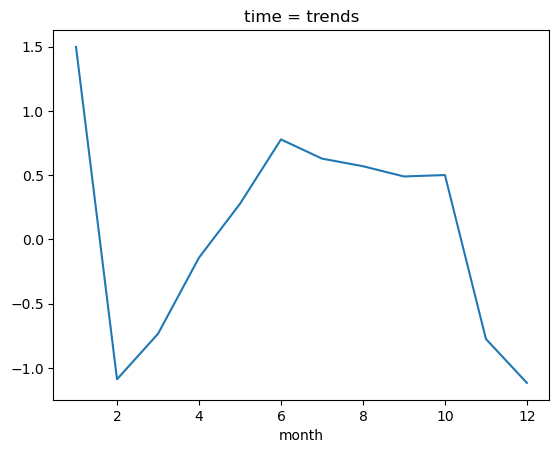

In [47]:
# Calculate the trend for each month 
# 2000-2014
x1 = np.arange(2000, 2015, 1)

trends_da.plot()